# 1. Test Convergence of Quantum-like Kalman Filter
Script:
1. Imports EEG data from DEAP for 2 of the 32 channels
2. Normalizes the data and forces the norm to be one for all samples
3. Load Quantum Estimator
4. Check convergence of estimator

## Open Tasks
- ~~Dump extra norm into imaginary~~ (2020-05-14)
- ~~comment~~  (2020-05-15)
- check controls results

# 2. Import

In [1]:
from quantum_2d_estimator import Schrodinger, QuantumEstimator #our custom scripts

In [2]:
import numpy as np
from control_kit import DynamicModel
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import pickle
from sklearn import preprocessing
import math

# 3. Load Data

In [3]:
subject=1 # choose subject, 1-40
path = '/media/tris/tris_files/DEAP_dataset/data_preprocessed_python/s0'+str(subject)+'.dat' #local path, may need modified
df = pickle.load(open(path, 'rb'), encoding='latin1') #deap is latin1 encoded 
data=df['data']
labels=df['labels']
np.shape(data) #check import shape, should be 40 trials x 40 channels x 8064 samples for each subject

(40, 40, 8064)

In [4]:
trial=5 #select a sample 1 to 40
channel0=2 #select first channel for trial
channel1=3 # select second channel for trial
last_sample=400 #Subsample data for simplicity, max 8064
fs=128 #hertz donut
time_end=last_sample/fs #sampling at 128

In [5]:
C=np.array([[1+0j, 0+0j]]) #Predefined C matrix; modify

In [6]:
data_channel0=data[trial,channel0,0:last_sample] #Subsample data for channel 0
data_channel1=data[trial,channel1,0:last_sample] #Subsample data for channel 1
data_channel0=data_channel0/(2*np.max(np.absolute(data_channel0))) #normalize
data_channel1=data_channel1/(2*np.max(np.absolute(data_channel1))) #normalize

In [7]:
np.max(np.absolute(data_channel1))

0.5

In [8]:
normed_data0=[] #allocate
normed_data1=[] #allocate
for i in range(0,last_sample): #For all the data points,
    normed0=data_channel0[i]+((math.sqrt(0.5-(np.absolute(data_channel0[i]**2))))*1j) #Add imaginary component to data making the norm equal to one
    normed_data0.append(normed0) #append to output
    normed1=data_channel1[i]+((math.sqrt(0.5-(np.absolute(data_channel1[i]**2))))*1j)
    normed_data1.append(normed1)
    #not sure this is the right solution. Born rule forces the norm of x(t) to be 1. Since the data is completely real, can we just dump the leftover norm into imaginary?

In [9]:
 np.linalg.norm(normed_data0)/math.sqrt(last_sample) #check norm, should be 1

0.7071067811865476

In [10]:
np.linalg.norm(normed_data1)/math.sqrt(last_sample) #check norm, should be 1

0.7071067811865476

In [11]:
data_one_trial=np.array([[normed_data0],[normed_data1]]) #combine two channels into a single array
data_one_trial=np.squeeze(data_one_trial) #squeeze out trailing dimension
data_one_trial=np.transpose(data_one_trial) #transpose to match quantum estimator
np.shape(data_one_trial) #check shape

(400, 2)

In [12]:
np.linalg.norm(data_one_trial)/math.sqrt(last_sample)

1.0000000000000002

# 4. Define Simulation Properties

In [13]:
def initial(angle, basis):
    """Quantum state initial conditions on a unit circle"""
    phi_1, phi_2 = basis()

    angle_d = np.rad2deg(angle)
    return np.cos(angle_d) * phi_1 + np.sin(angle_d) * phi_2

In [14]:
def basis_vectors():
    """ Orthonormal basis for the 2d system. """
    phi_1 = (1 / np.sqrt(2)) * np.array([1, 1j])
    phi_2 = (1 / np.sqrt(2)) * np.array([1, -1j])

    return phi_1, phi_2

In [15]:
def probability(basis, x):
    """ Quantum probability.

    Args:
        basis: function returning basis vector list.
        x: quantum state vector (1D numpy array)

    Returns:
        list (generator) of quantum probabilities.
    """
    for phi_k in basis():
        yield abs(np.vdot(phi_k, x))**2

# 5. Run Kalman Filter

In [16]:
""" Simulation. """

""" Simulation time vector. """
n_points = last_sample
t_final = time_end
t = np.linspace(0, t_final, n_points)

""" Pauli Matrices and the corresponding the Hamiltonian."""
sigma_0 = np.eye(2)

sigma_1=np.array([[0, 1],
                    [1, 0]])

sigma_2 = np.array([[0, -1j],
                    [1j, 0]])

sigma_3=np.array([[1, 0],
                    [0, -1]])

alpha = 0.1

h = sigma_0 + (alpha * sigma_2) # Hamiltonian

""" Quantum system (plant)."""
x0 = initial(10, basis_vectors)
quantum = Schrodinger(x0, t, h, name="2d")

""" Quantum state estimator. """
k = np.array([[2 + 2j],
              [(-2 / alpha) + ((alpha**2 - 1) / alpha)*1j]])  # Estimator gain matrix.


x0_estimator = initial(20, basis_vectors)
quantum_estimator = QuantumEstimator(x0_estimator, t, h, k, quantum.y, name="2d_est")

# Storage for quantum probabilities (plant).
alpha = [np.zeros((n_points, 1)) for k in range(2)]
for i, alpha_k in enumerate(probability(basis_vectors, x0)):
    alpha[i][0] = alpha_k

# Storage for quantum probabilities (estimator).
alpha_est = [np.zeros((n_points, 1)) for k in range(2)]
for i, alpha_k in enumerate(probability(basis_vectors, x0_estimator)):
    alpha_est[i][0] = alpha_k

""" Simulation loop. """
for k in range(1, n_points):
    ts = t[k-1], t[k]
    quantum_estimator.u = C@data_one_trial[k,:]

    quantum.integrate(ts)
    quantum_estimator.integrate(ts)

    for i, alpha_k in enumerate(probability(basis_vectors, data_one_trial[k,:])):
        alpha[i][k] = alpha_k

    for i, alpha_k in enumerate(probability(basis_vectors, quantum_estimator.x)):
        alpha_est[i][k] = alpha_k

# 6. Plot Results

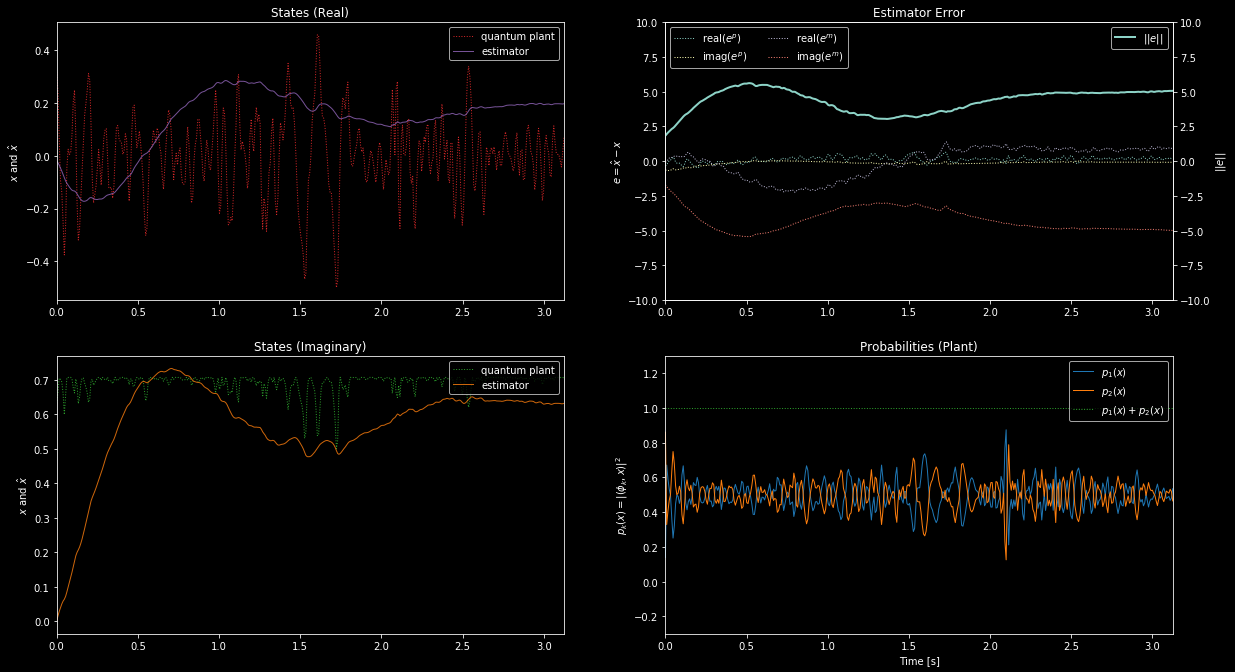

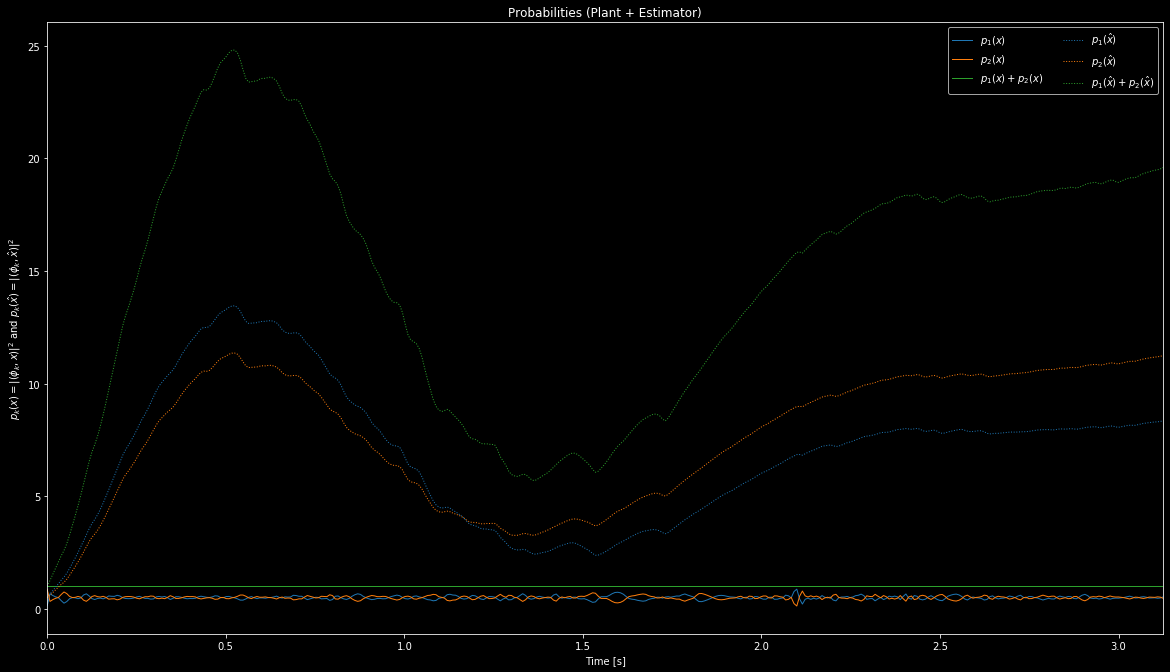

In [17]:
mpl.rcParams["savefig.facecolor"] = 'white'
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(2, 2)

    ratio = 16/9
    width = 20
    height = 20 / ratio
    fig.set_figheight(height)
    fig.set_figwidth(width)

    ax[0, 0].plot(t, np.real(data_one_trial[:, 0]), ls=':', color='C3', lw=1, label='quantum plant')
    ax[0, 0].plot(t, np.real(quantum_estimator.xa[:, 0]), color='C4', alpha=0.8, lw=1, label='estimator')
    ax[0, 0].set_xlim([t[0], t[-1]])
    ax[0, 0].set_title('States (Real)')
    ax[0, 0].set_ylabel('$x$ and $\\hat{x}$')
    ax[0, 0].legend(loc='upper right')

    ax[1, 0].plot(t, np.imag(data_one_trial[:, 0]), ls=':', color='C2', lw=1, label='quantum plant')
    ax[1, 0].plot(t, np.imag(quantum_estimator.xa[:, 0]), color='C1', alpha=0.8, lw=1, label='estimator')
    ax[1, 0].set_xlim([t[0], t[-1]])
    ax[1, 0].set_title('States (Imaginary)')
    ax[1, 0].set_ylabel('$x$ and $\\hat{x}$')
    ax[1, 0].legend(loc='upper right')

    e = quantum_estimator.xa - data_one_trial
    ax[0, 1].plot(t, np.real(e[:, 0]), lw=1, label='real($e^p$)', ls=':')
    ax[0, 1].plot(t, np.imag(e[:, 0]), lw=1, label='imag($e^p$)', ls=':')
    ax[0, 1].plot(t, np.real(e[:, 1]), lw=1, label='real($e^m$)', ls=':')
    ax[0, 1].plot(t, np.imag(e[:, 1]), lw=1, label='imag($e^m$)', ls=':')
    ax[0, 1].set_xlim([t[0], t[-1]])
    ax[0, 1].set_title('Estimator Error')
    ax[0, 1].set_ylim([-10, 10])
    ax[0, 1].set_ylabel('$e = \\hat{x} - x$')
    ax_e_norm = ax[0, 1].twinx()
    ax_e_norm.plot(t, np.linalg.norm(e, axis=1), lw=2, label='$\|\|e\|\|$')
    ax_e_norm.set_ylabel('$\|\|e\|\|$')
    ax_e_norm.legend(loc='upper right')
    ax_e_norm.set_ylim([-10, 10])
    ax[0, 1].legend(loc='upper left', ncol=2)

    ax[1, 1].plot(t, alpha[0], label='$p_1(x)$', lw=1, color='C0')
    ax[1, 1].plot(t, alpha[1], label='$p_2(x)$', lw=1, color='C1')
    ax[1, 1].plot(t, alpha[0] + alpha[1], label='$p_1(x) + p_2(x)$', ls=':', lw=1, color='C2')
    ax[1, 1].set_xlim([t[0], t[-1]])
    ax[1, 1].set_ylim([-0.3, 1.3])
    ax[1, 1].set_xlabel('Time [s]')
    ax[1, 1].set_title('Probabilities (Plant)')
    ax[1, 1].set_ylabel('$p_k(x) = | (\\phi_k, x) |^2$')
    ax[1, 1].legend(loc='upper right')
    plt.savefig("default_Kalman1.png", dpi=300)

    fig, ax = plt.subplots(1, 1)

    ratio = 16/9
    width = 20
    height = 20 / ratio
    fig.set_figheight(height)
    fig.set_figwidth(width)

    ax.plot(t, alpha[0], lw=1, color='C0', label='$p_1(x)$')
    ax.plot(t, alpha[1], lw=1, color='C1', label='$p_2(x)$')
    ax.plot(t, alpha[0] + alpha[1], lw=1, color='C2', label='$p_1(x)+p_2(x)$')
    ax.plot(t, alpha_est[0], lw=1, color='C0', ls=':', label='$p_1(\\hat{x})$')
    ax.plot(t, alpha_est[1], lw=1, color='C1', ls=':', label='$p_2(\\hat{x})$')
    ax.plot(t, alpha_est[0] + alpha_est[1], lw=1, color='C2', ls=':', label='$p_1(\\hat{x}) + p_2(\\hat{x})$')
    ax.set_xlim([t[0], t[-1]])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('$p_k(x) = | (\\phi_k, x) |^2$ and $p_k(\\hat{x}) = | (\\phi_k, \\hat{x}) |^2$')
    ax.set_title('Probabilities (Plant + Estimator)')
    ax.legend(ncol=2)
    plt.savefig("default_Kalman2.png", dpi=300)
plt.show()


# 7. Some Mild Guess and Check

In [18]:
C=np.array([[1+0j, 0+0j]]) #Predefined C matrix; modify

In [19]:
""" Simulation. """

""" Simulation time vector. """
n_points = last_sample
t_final = time_end
t = np.linspace(0, t_final, n_points)

""" Pauli Matrices and the corresponding the Hamiltonian."""
sigma_0 = np.eye(2)

sigma_1=np.array([[0, 1],
                    [1, 0]])

sigma_2 = np.array([[0, -1j],
                    [1j, 0]])

sigma_3=np.array([[1, 0],
                    [0, -1]])

alpha = 0.8

h = sigma_0 + (alpha * sigma_2) # Hamiltonian

""" Quantum system (plant)."""
x0 = initial(10, basis_vectors)
quantum = Schrodinger(x0, t, h, name="2d")

""" Quantum state estimator. """
k = np.array([[2 + 2j],
              [(-2 / alpha) + ((alpha**2 - 1) / alpha)*1j]])  # Estimator gain matrix.

k=40*k

x0_estimator = initial(20, basis_vectors)
quantum_estimator = QuantumEstimator(x0_estimator, t, h, k, quantum.y, name="2d_est")

# Storage for quantum probabilities (plant).
alpha = [np.zeros((n_points, 1)) for k in range(2)]
for i, alpha_k in enumerate(probability(basis_vectors, x0)):
    alpha[i][0] = alpha_k

# Storage for quantum probabilities (estimator).
alpha_est = [np.zeros((n_points, 1)) for k in range(2)]
for i, alpha_k in enumerate(probability(basis_vectors, x0_estimator)):
    alpha_est[i][0] = alpha_k

""" Simulation loop. """
for k in range(1, n_points):
    ts = t[k-1], t[k]
    quantum_estimator.u = C@data_one_trial[k,:]

    quantum.integrate(ts)
    quantum_estimator.integrate(ts)

    for i, alpha_k in enumerate(probability(basis_vectors, data_one_trial[k,:])):
        alpha[i][k] = alpha_k

    for i, alpha_k in enumerate(probability(basis_vectors, quantum_estimator.x)):
        alpha_est[i][k] = alpha_k

In [20]:
[phi_1,phi_2]=basis_vectors()

In [21]:
abs(np.vdot(phi_1, data_one_trial[3,:]))

0.729406632179498

In [22]:
data_one_trial[3,:]

array([-0.0933404 +0.70091909j, -0.13805517+0.69349893j])

In [23]:
abs(np.vdot(phi_1, data_one_trial[3,:]))**2

0.5320340350674374

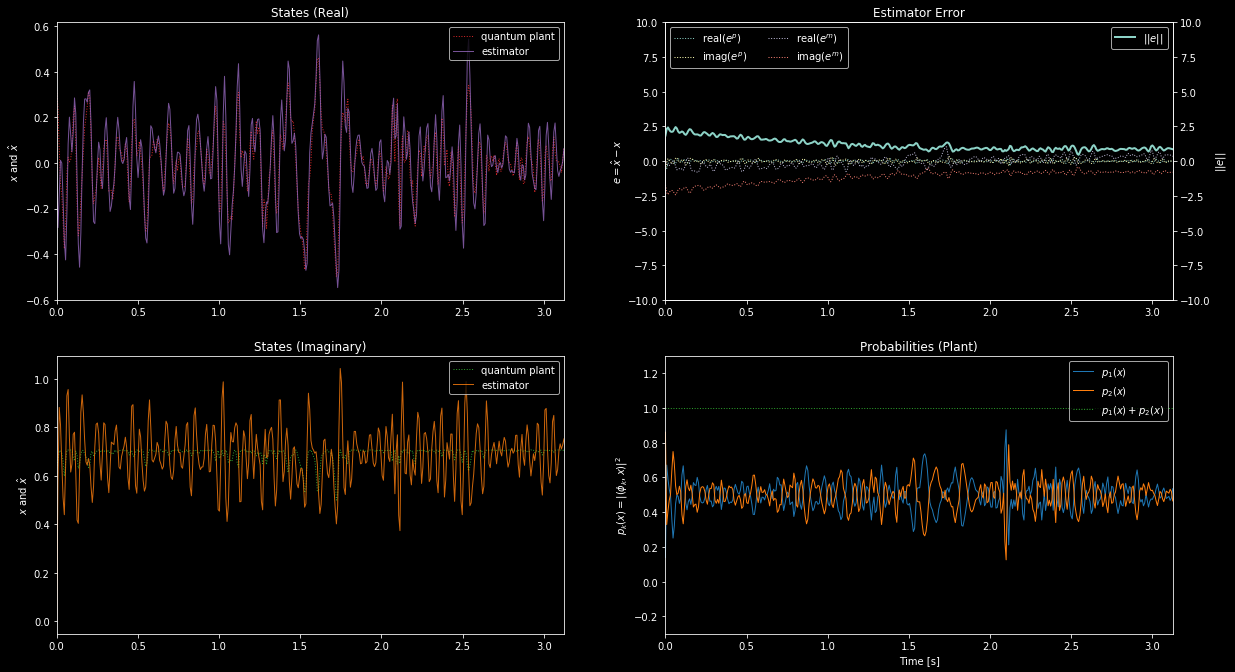

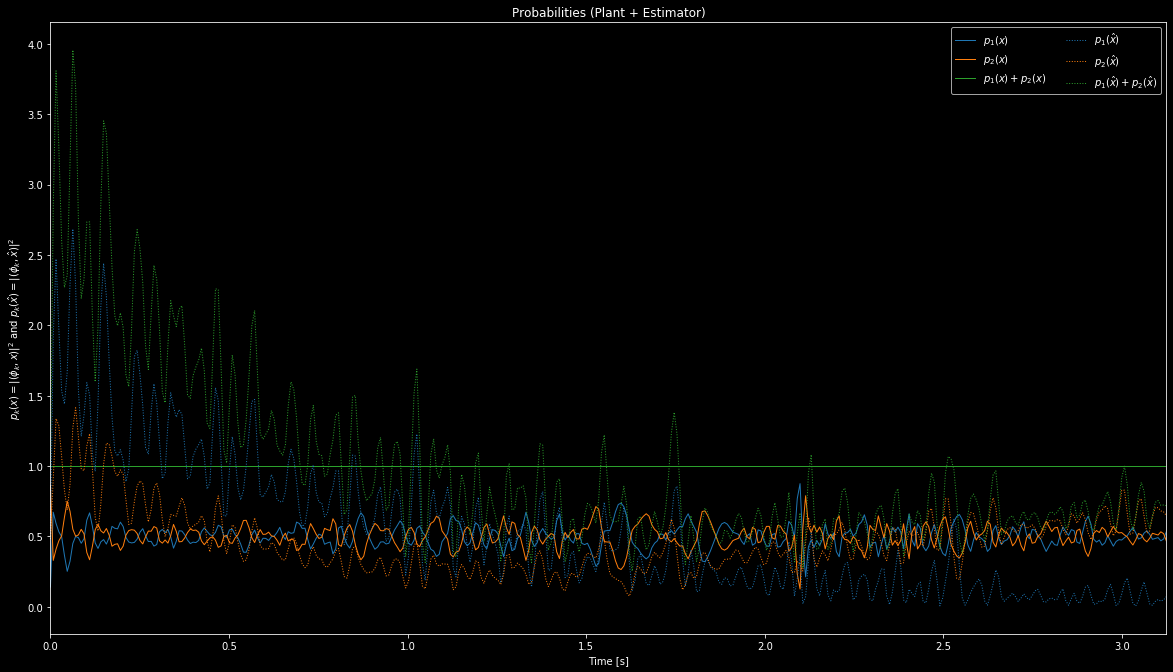

In [24]:
mpl.rcParams["savefig.facecolor"] = 'white'
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(2, 2)

    ratio = 16/9
    width = 20
    height = 20 / ratio
    fig.set_figheight(height)
    fig.set_figwidth(width)

    ax[0, 0].plot(t, np.real(data_one_trial[:, 0]), ls=':', color='C3', lw=1, label='quantum plant')
    ax[0, 0].plot(t, np.real(quantum_estimator.xa[:, 0]), color='C4', alpha=0.8, lw=1, label='estimator')
    ax[0, 0].set_xlim([t[0], t[-1]])
    ax[0, 0].set_title('States (Real)')
    ax[0, 0].set_ylabel('$x$ and $\\hat{x}$')
    ax[0, 0].legend(loc='upper right')

    ax[1, 0].plot(t, np.imag(data_one_trial[:, 0]), ls=':', color='C2', lw=1, label='quantum plant')
    ax[1, 0].plot(t, np.imag(quantum_estimator.xa[:, 0]), color='C1', alpha=0.8, lw=1, label='estimator')
    ax[1, 0].set_xlim([t[0], t[-1]])
    ax[1, 0].set_title('States (Imaginary)')
    ax[1, 0].set_ylabel('$x$ and $\\hat{x}$')
    ax[1, 0].legend(loc='upper right')

    e = quantum_estimator.xa - data_one_trial
    ax[0, 1].plot(t, np.real(e[:, 0]), lw=1, label='real($e^p$)', ls=':')
    ax[0, 1].plot(t, np.imag(e[:, 0]), lw=1, label='imag($e^p$)', ls=':')
    ax[0, 1].plot(t, np.real(e[:, 1]), lw=1, label='real($e^m$)', ls=':')
    ax[0, 1].plot(t, np.imag(e[:, 1]), lw=1, label='imag($e^m$)', ls=':')
    ax[0, 1].set_xlim([t[0], t[-1]])
    ax[0, 1].set_title('Estimator Error')
    ax[0, 1].set_ylim([-10, 10])
    ax[0, 1].set_ylabel('$e = \\hat{x} - x$')
    ax_e_norm = ax[0, 1].twinx()
    ax_e_norm.plot(t, np.linalg.norm(e, axis=1), lw=2, label='$\|\|e\|\|$')
    ax_e_norm.set_ylabel('$\|\|e\|\|$')
    ax_e_norm.legend(loc='upper right')
    ax_e_norm.set_ylim([-10, 10])
    ax[0, 1].legend(loc='upper left', ncol=2)

    ax[1, 1].plot(t, alpha[0], label='$p_1(x)$', lw=1, color='C0')
    ax[1, 1].plot(t, alpha[1], label='$p_2(x)$', lw=1, color='C1')
    ax[1, 1].plot(t, alpha[0] + alpha[1], label='$p_1(x) + p_2(x)$', ls=':', lw=1, color='C2')
    ax[1, 1].set_xlim([t[0], t[-1]])
    ax[1, 1].set_ylim([-0.3, 1.3])
    ax[1, 1].set_xlabel('Time [s]')
    ax[1, 1].set_title('Probabilities (Plant)')
    ax[1, 1].set_ylabel('$p_k(x) = | (\\phi_k, x) |^2$')
    ax[1, 1].legend(loc='upper right')
    plt.savefig("high_gain_Kalman1.png", dpi=300)

    fig, ax = plt.subplots(1, 1)

    ratio = 16/9
    width = 20
    height = 20 / ratio
    fig.set_figheight(height)
    fig.set_figwidth(width)

    ax.plot(t, alpha[0], lw=1, color='C0', label='$p_1(x)$')
    ax.plot(t, alpha[1], lw=1, color='C1', label='$p_2(x)$')
    ax.plot(t, alpha[0] + alpha[1], lw=1, color='C2', label='$p_1(x)+p_2(x)$')
    ax.plot(t, alpha_est[0], lw=1, color='C0', ls=':', label='$p_1(\\hat{x})$')
    ax.plot(t, alpha_est[1], lw=1, color='C1', ls=':', label='$p_2(\\hat{x})$')
    ax.plot(t, alpha_est[0] + alpha_est[1], lw=1, color='C2', ls=':', label='$p_1(\\hat{x}) + p_2(\\hat{x})$')
    ax.set_xlim([t[0], t[-1]])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('$p_k(x) = | (\\phi_k, x) |^2$ and $p_k(\\hat{x}) = | (\\phi_k, \\hat{x}) |^2$')
    ax.set_title('Probabilities (Plant + Estimator)')
    ax.legend(ncol=2)
    plt.savefig("high_gain_Kalman2.png", dpi=300)
plt.show()
